### ACSIncome - Retiring Adults experiment

- **Task:** Predict whether US working adults' income is above $50,000 or not.
- **Dataset:** [[2108.04884] Retiring Adult: New Datasets for Fair Machine Learning](https://arxiv.org/pdf/2108.04884)
- **Models:**
  - *network_standard:* 2-layer fully-connected network trained in a standard manner using the cross-entropy loss
  - *network_fair:* 2-layer fully-connected network trained using the SenSeI individually fair algo with distance_x = Logistic regression metric and distance_y = Squared euclidean distance
- **Metrics:**
  - *Accuracy:* Percentage correct predictions of income in the test set
  - *Balanced accuracy:* (true positive rate + true negative rate) / 2
  - *Equal opportunity violation:* True positive rate for white group - True positive rate for black group
- **Results:** 
  - Training a 2-layer FC network on data from California and testing it across all US states leads to unpredictable results

In [6]:
# uncomment and install dependencies before continuing
#!pip install inFairness folktables

In [1]:
import sys, os
sys.path.append("../../")

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from inFairness.fairalgo import SenSeI
from inFairness import distances
from inFairness.auditor import SenSRAuditor, SenSeIAuditor

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import RA_data
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
protected_vars = ["SEX", "RAC1P"]
train_data, test_data = RA_data.load_data("CA", protected_vars)

In [6]:
class AdultDataset(Dataset):
    def __init__(self, data, labels, groups=None):
        self.data = data
        self.labels = labels
        self.groups = groups

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        if self.groups is not None:
            group = self.groups[idx]
            return data, label, group
        
        return data, label
    
    def __len__(self):
        return len(self.labels)

In [7]:
device = torch.device("cpu")

# Create the training dataset
X_train, X_train_protected, y_train = train_data
train_ds =  AdultDataset(X_train, y_train)
train_dl =  DataLoader(train_ds, batch_size=128, shuffle=True)

In [8]:
def get_test_dl(state):
    X_test, y_test, grp_test = test_data[state]
    test_ds =  AdultDataset(X_test, y_test, grp_test)
    test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)
    return test_dl

In [9]:
# Create a fully connected neural network

class Model(nn.Module):

    def __init__(self, input_size, output_size):

        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fcout = nn.Linear(100, output_size)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x

### Standard training

In [10]:
input_size = X_train.shape[1]
output_size = 2

network_standard = Model(input_size, output_size).to(device)
optimizer = torch.optim.Adam(network_standard.parameters(), lr=1e-3)
loss_fn = F.cross_entropy

EPOCHS = 10

In [11]:
network_standard.train()

for epoch in range(EPOCHS):

    for x, y in train_dl:

        x, y = x.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        y_pred = network_standard(x).squeeze()
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'{epoch} completed')

0 completed


In [12]:
eval_metrics =  {
    'states': [],
    'acc': [],
    'bacc': [],
    'eqop': []
}

for state in test_data.keys():
    testdl = get_test_dl(state)
    acc = metrics.accuracy(network_standard, testdl, device)
    bacc = metrics.balanced_accuracy(network_standard, testdl, device)
    eq = metrics.equal_opportunity(network_standard, testdl, device)

    eval_metrics['states'].append(state)
    eval_metrics['acc'].append(acc)
    eval_metrics['bacc'].append(bacc)
    eval_metrics['eqop'].append(eq)

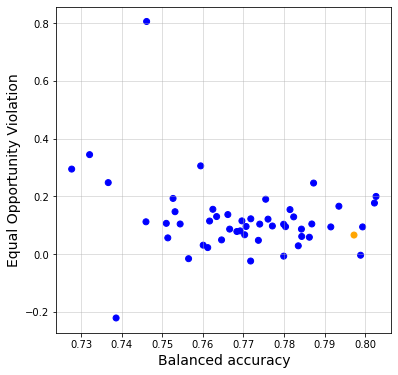

In [13]:
x = eval_metrics['bacc']
y = eval_metrics['eqop']
c = ['blue' if eval_metrics['states'][idx] != 'CA' else 'orange' for idx in range(len(eval_metrics['states']))]


plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=c)
plt.grid(alpha=0.5)
plt.xlabel('Balanced accuracy', fontsize=14)
plt.ylabel('Equal Opportunity Violation', fontsize=14)
plt.show()

### Individually fair training

In [14]:
network_fair = Model(input_size, output_size).to(device)
optimizer = torch.optim.Adam(network_fair.parameters(), lr=1e-3)
lossfn = F.cross_entropy

distance_x = distances.LogisticRegSensitiveSubspace()
distance_y = distances.SquaredEuclideanDistance()

distance_x.fit(X_train, data_SensitiveAttrs=X_train_protected)
distance_y.fit(num_dims=output_size)

distance_x.to(device)
distance_y.to(device)

In [15]:
rho = 5.0
eps = 0.1
auditor_nsteps = 100
auditor_lr = 1e-3

fairalgo = SenSeI(network_fair, distance_x, distance_y, lossfn, rho, eps, auditor_nsteps, auditor_lr)

In [16]:
fairalgo.train()

for epoch in range(EPOCHS):
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        result = fairalgo(x, y)
        result.loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'{epoch} completed')

0 completed


In [17]:
fair_eval_metrics =  {
    'states': [],
    'acc': [],
    'bacc': [],
    'eqop': []
}

for state in test_data.keys():
    testdl = get_test_dl(state)
    acc = metrics.accuracy(network_fair, testdl, device)
    bacc = metrics.balanced_accuracy(network_fair, testdl, device)
    eq = metrics.equal_opportunity(network_fair, testdl, device)

    fair_eval_metrics['states'].append(state)
    fair_eval_metrics['acc'].append(acc)
    fair_eval_metrics['bacc'].append(bacc)
    fair_eval_metrics['eqop'].append(eq)

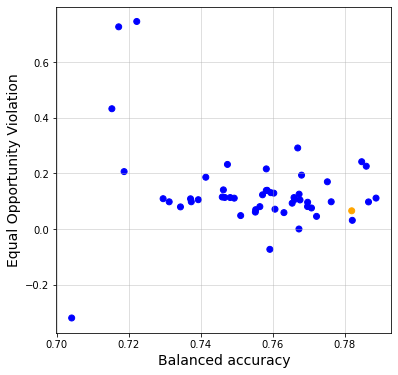

In [18]:
x = fair_eval_metrics['bacc']
y = fair_eval_metrics['eqop']
c = ['blue' if fair_eval_metrics['states'][idx] != 'CA' else 'orange' for idx in range(len(fair_eval_metrics['states']))]


plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=c)
plt.grid(alpha=0.5)
plt.xlabel('Balanced accuracy', fontsize=14)
plt.ylabel('Equal Opportunity Violation', fontsize=14)
plt.show()

#### Let's now audit the two models and check for their individua fairness compliance

In [21]:
# Auditing using the SenSR Auditor

audit_nsteps = 1000
audit_lr = 0.1

auditor = SenSRAuditor(loss_fn=loss_fn, distance_x=distance_x, num_steps=audit_nsteps, lr=audit_lr, max_noise=0.5, min_noise=-0.5)

X_test, y_test, _ = test_data["CA"]
audit_result_stdmodel = auditor.audit(network_standard, X_test, y_test, lambda_param=10.0, audit_threshold=1.15)
audit_result_fairmodel = auditor.audit(network_fair, X_test, y_test, lambda_param=10.0, audit_threshold=1.15)

print("="*100)
print(f"Loss ratio (Standard model) : {audit_result_stdmodel.lower_bound}. Is model fair: {audit_result_stdmodel.is_model_fair}")
print(f"Loss ratio (fair model) : {audit_result_fairmodel.lower_bound}. Is model fair: {audit_result_fairmodel.is_model_fair}")
print("-"*100)
print("\t As signified by these numbers, the fair model is fairer than the standard model")
print("="*100)

Loss ratio (Standard model) : 1.4647548315461059. Is model fair: False
Loss ratio (fair model) : 1.1409702763735605. Is model fair: True
----------------------------------------------------------------------------------------------------
	 As signified by these numbers, the fair model is fairer than the standard model


In [23]:
# Auditing using the SenSeI Auditor

audit_nsteps = 500
audit_lr = 0.001

auditor = SenSeIAuditor(distance_x=distance_x, distance_y=distance_y, num_steps=audit_nsteps, lr=audit_lr, max_noise=0.5, min_noise=-0.5)

X_test, y_test, _ = test_data["CA"]
audit_result_stdmodel = auditor.audit(network_standard, X_test, y_test, loss_fn, audit_threshold=1.15, lambda_param=50.0)
audit_result_fairmodel = auditor.audit(network_fair, X_test, y_test, loss_fn, audit_threshold=1.15, lambda_param=50.0)

print("="*100)
print(f"Loss ratio (Standard model) : {audit_result_stdmodel.lower_bound}. Is model fair: {audit_result_stdmodel.is_model_fair}")
print(f"Loss ratio (fair model) : {audit_result_fairmodel.lower_bound}. Is model fair: {audit_result_fairmodel.is_model_fair}")
print("-"*100)
print("\t As signified by these numbers, the fair model is fairer than the standard model")
print("="*100)

Loss ratio (Standard model) : 25584951.625639636. Is model fair: False
Loss ratio (fair model) : 41094.68053808146. Is model fair: False
----------------------------------------------------------------------------------------------------
	 As signified by these numbers, the fair model is fairer than the standard model
